In [1]:
# from model import classification_m
from data.data import data_preprocessing, load_pretrained_embedding, apply_tokenizer
from models.model import LSTM_model, BidirLSTM_model 
from utility.utility import plot_confusion_matrix, plot_precision_recall_curve, plot_ROC, plot_data_balance, data_analysis, get_classification_report, model_performance_curves
import numpy as np
import tensorflow 
from tensorflow.keras.callbacks import TensorBoard
import datetime, os

In [2]:
# run data preprocessing
train_df_path = './labeledTrainData.tsv'
test_df_path = "./testData.tsv"
train_corpus, test_corpus, y_train, y_test = data_preprocessing(train_df_path, test_df_path)

(22504, 6)


d:\ML_task_IMDB_data\data\data.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df["rating"] > 7, "Rating"] = 1
d:\ML_task_IMDB_data\data\data.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Rating"] = df["Rating"].astype(int)


In [3]:
# use pretrained embedding and process the train and test data
embedding_matrix, tokenizered_corpus, voc_length = load_pretrained_embedding('./glove.6B.50d.txt', train_corpus)
embedding_matrix_test, tokenizered_corpus_test, voc_length_test = load_pretrained_embedding('./glove.6B.50d.txt', test_corpus)

In [4]:
def start_training(use_LSTM, max_words, matrix, vec_size, dropout_p, hidden_neurons, lstm_neurons):
    current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    if use_LSTM:
        print("running the model with LSTM layer")
        model = LSTM_model(max_words, matrix, vec_size, dropout_p, hidden_neurons, lstm_neurons)
        model_type = "LSTM"
        save_runs = 'D:\ML_task_IMDB_data\runs\LSTM_model'
    else:
        print("running model with bidirectional layer")
        model = BidirLSTM_model(max_words, matrix, vec_size, dropout_p, hidden_neurons, lstm_neurons)
        model_type = "Bidir_LSTM"
        save_runs = 'D:\ML_task_IMDB_data\runs\Bidir_LSTM_model'


    checkpoint_cb = tensorflow.keras.callbacks.ModelCheckpoint(f"D:/ML_task_IMDB_data/training_weights/{model_type}_classification_{current_time}.keras", save_best_only=True)
    early_stopping_cb = tensorflow.keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=10)
    
    return model, checkpoint_cb, early_stopping_cb, model_type, save_runs
    

In [5]:
model, checkpoint_cb, early_stopping_cb, model_type, save_runs = start_training(use_LSTM  = False, max_words = voc_length, matrix = embedding_matrix, vec_size = 50, dropout_p=0.5,hidden_neurons=8,lstm_neurons=16)

start_time = datetime.datetime.now()

model_history = model.fit(
    tokenizered_corpus,  # Training data
    y_train,             # Training labels
    batch_size=64,
    epochs=40,
    verbose=1,
    validation_split=0.3,  # Percentage of training data to use for validation
    # callbacks=[checkpoint_cb, early_stopping_cb, tensorboard_callback]
    callbacks=[checkpoint_cb, early_stopping_cb],
    shuffle = True
)

end_time = datetime.datetime.now()
training_time = end_time - start_time
print(f"time required for the training is { training_time}")

running model with bidirectional layer

Epoch 1/40


247/247 [==============================] - 23s 79ms/step - loss: 0.5315 - accuracy: 0.7362 - val_loss: 0.4161 - val_accuracy: 0.8181
Epoch 2/40
247/247 [==============================] - 18s 73ms/step - loss: 0.3949 - accuracy: 0.8268 - val_loss: 0.3777 - val_accuracy: 0.8403
Epoch 3/40
247/247 [==============================] - 17s 69ms/step - loss: 0.3541 - accuracy: 0.8470 - val_loss: 0.3724 - val_accuracy: 0.8457
Epoch 4/40
247/247 [==============================] - 18s 74ms/step - loss: 0.3299 - accuracy: 0.8619 - val_loss: 0.3884 - val_accuracy: 0.8440
Epoch 5/40
247/247 [==============================] - 20s 82ms/step - loss: 0.3153 - accuracy: 0.8671 - val_loss: 0.3559 - val_accuracy: 0.8537
Epoch 6/40
247/247 [==============================] - 20s 79ms/step - loss: 0.2946 - accuracy: 0.8767 - val_loss: 0.3535 - val_accuracy: 0.8513
Epoch 7/40
247/247 [==============================] - 20s 82ms/step - loss: 0.2731 - accuracy:

In [6]:
score = model.predict(tokenizered_corpus_test)

710/710 [==============================] - 11s 14ms/step


In [7]:
# threshold can be adjust 
threshold = 0.5
y_pred = (score > threshold).astype(int)

confusion matrix for Bidir_LSTM


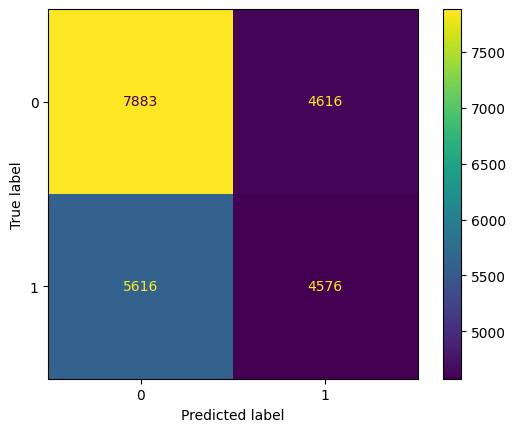

In [8]:
plot_confusion_matrix(y_test, y_pred, model_type)

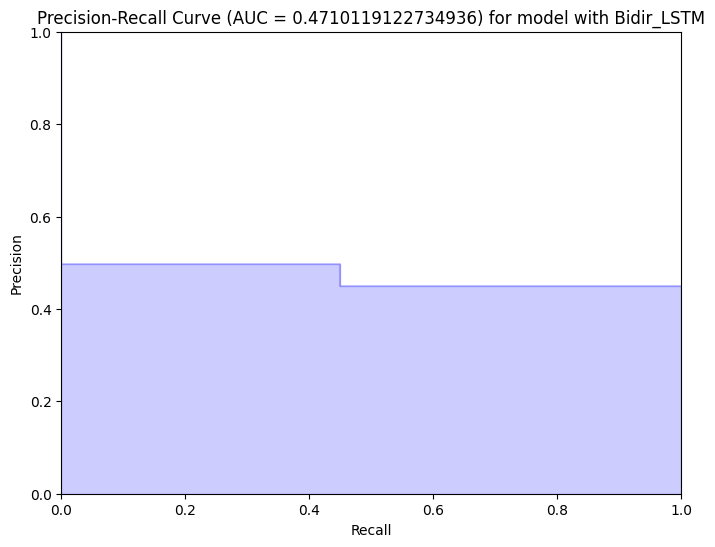

In [9]:
plot_precision_recall_curve(y_test, y_pred,model_type)

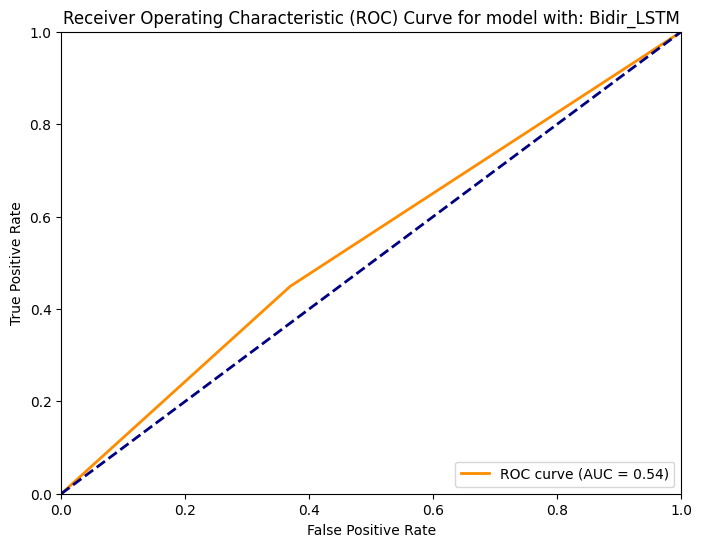

In [10]:
plot_ROC(y_test, y_pred, model_type)

In [11]:
cls_accuracy, cls_report = get_classification_report(y_test, y_pred)

In [12]:
print(f"the classifiation accuray is: { round(cls_accuracy, 3)}")
print("the classifiation accuray is: {cls_report}")
print(cls_report)

the classifiation accuray is: 0.549
the classifiation accuray is: {cls_report}
              precision    recall  f1-score   support

           0       0.58      0.63      0.61     12499
           1       0.50      0.45      0.47     10192

    accuracy                           0.55     22691
   macro avg       0.54      0.54      0.54     22691
weighted avg       0.55      0.55      0.55     22691



**For 40 epochs using LSTM layer, achieved the 0.559 accuracy. Model is saved at D:\ML_task_IMDB_data\training_weights\LSTM_classification_20240129-184420.keras**

**For 40 epochs using Bidir LSTM layer, achieved the 0.549 accuracy. Model is saved at training_weights\Bidir_LSTM_classification_20240129-191100.keras**

In [14]:
import matplotlib.pyplot as plt

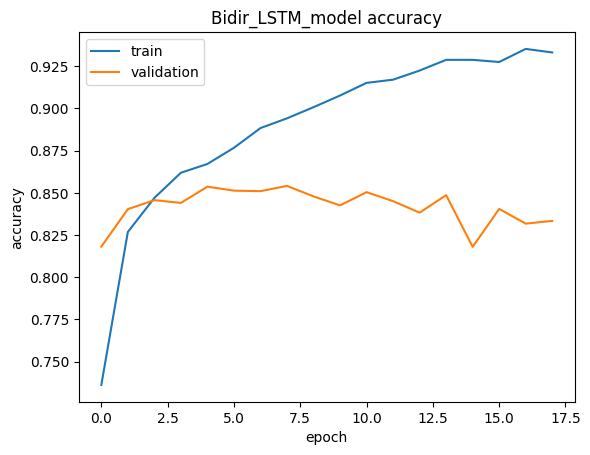

In [15]:
plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])
plt.title('Bidir_LSTM_model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.savefig("Accuracy curve LSTM.pdf", format = 'pdf')
plt.show()

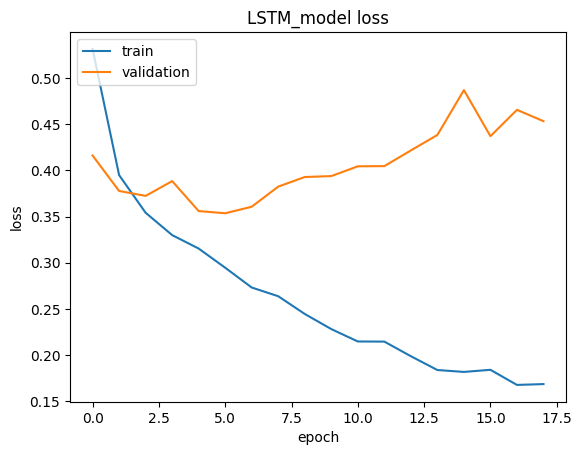

In [16]:
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('LSTM_model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.savefig("loss curve LSTM.pdf", format = 'pdf')
plt.show()

<span style="font-size: 48px;">Note on Model Performance.</span>

*For performance of factors are consider: Training curves (accuarcy and loss) Precision, Recall, F1-score, Classification accuarcy, Classification report, ROC curve, Precision-Recall Curve*

**Q2. Explain the performance differences on validation (from labeledTrainData) and test (testData) datasets.**

*When assessing the model's performance using the validation and test data, particularly focusing on the accuracy and loss curves of the **LSTM model**, it becomes evident that the model has undergone effective training without succumbing to overfitting. However, it has not yet reached the global minimum. Subsequently, when predictions are executed on the test data, a notable occurrence of false positives (FP) and false negatives (FN) is observed. Despite these discrepancies, the model has achieved satisfactory average precision and recall metrics.*

*One contributing factor to the observed performance on the test data is the limitation of the training dataset. The model's ability to generalize is hindered due to the scarcity of diverse training data. I tried to enhance the model's complexity by introducing additional layers have been made, resulting in overfitting (as verified through experimentation). Therefore, the key takeaway is that training the model on a larger, more diverse dataset is crucial for achieving robust generalization.*

*The training dataset comprises 25,000 samples, inclusive of both training and validation data, while the size of the test dataset is also 25,000. The datasets are unique, implying differences in features between the training and test data. To optimize prediction results, it is imperative to train the model on a sizable dataset, facilitating improved performance during the prediction phase.*

*3. Have 2 different models (Model with LSTM layer and model Bidirectional layer) for the problem and explain the reason behind the different performances of these models.*

*The LSTM-based model incorporates a dense layer and an LSTM layer, complemented by dropout and regularization parameters (refer to the evaluation results provided below). While it has not yet converged to the global minimum, additional training is likely to lead to convergence. This observation suggests that the model is not currently overfitting; rather, it requires further training to optimize its performance.*
**So simple and well regularized (l2 regularization and dropout) architecture leads good performace of model with LSTM layer on train and validation dataset.**


*The Bidirectional LSTM model was trained without the use of regularization and a hidden dense layer. By examining the accuracy curve (bidir_LSTM_accuracy_curve_40epochs.pdf.png) and loss curve (bidir_LSTM_loss_curve_40epochs.pdf.png), it is apparent that the model is exhibiting signs of overfitting. This is evident from the divergence of the accuracy and loss curves, indicating that while the model is learning well from the training data, it struggles to generalize effectively to the validation dataset. To address this issue, further improvements can be made by incorporating regularization techniques into the training process and by improving the architecture.*


**Mainly model has different architectures (kind of and nuber of layers used), also type of regularization technique used so the models has different performance on train and validation data.**

<span style="font-size: 48px;">LSTM based model Performance.</span>

*Accuracy curve and Loss curve of LSTM*
<div style="display: flex;">
    <img src="accuracy_curve_LSTM_40epoch.png" alt="Image 1" style="width: 50%;">
    <img src="loss_curve_LSTM_40epoch.png" alt="Image 2" style="width: 50%;">
</div>

*Classfication report and confusion matrix of LSTM*
<div style="display: flex;">
    <img src="Classification_report_LSTM_40epoch.png" alt="Image 1" style="width: 50%;">
    <img src="LSTM_confusionmetric_40epoch.png" alt="Image 2" style="width: 50%;">
</div>

<span style="font-size: 48px;">Bidirectional LSTM based model Performance.</span>

*Performance of Bidirectional LSTM without regularization*
<div style="display: flex;">
    <img src="accuracy_curve_bidir_LSTM_40epoch.png" alt="Image 1" style="width: 50%;">
    <img src="loss_curve_Bidir_LSTM_40epoch.png" alt="Image 2" style="width: 50%;">
</div>

*Classfication report and confusion matrix of LSTM*
<div style="display: flex;">
    <img src="Classification_report_Bidir_LSTM_40epoch.png" alt="Image 1" style="width: 50%;">
    
</div>

**Some important points:**

*PretrainedEmbedding: used pretrained embedding GLOVE trained on 6billion words, we have used glove with 50 vector size glove.6B.50d.txt. I have tried glove.6B.50d.txt has show best results.*

*Architectures has been trained using loss function binary_crossentropy, Adam optimizer with learning rate of 0.01 (can be adjusted based on needs)*


*For further hyper-parameter tunning the optuna can be used.*

<span style="font-size: 48px;">Thank you so much.</span>